In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

import cupy as cp

from jlinops import check_adjoint, get_device

# DiagonalLinearOperator

In [2]:
from jlinops import DiagonalOperator

In [3]:
d = np.random.normal(size=50)
D = DiagonalOperator(d)
print(np.linalg.norm( (D @ np.ones(50)) - (d*np.ones(50) ) ))
print(check_adjoint(D))

0.0
True


In [4]:
# Bring onto GPU, check again
Dcp = D.to_gpu()
print(Dcp.device)
print(cp.linalg.norm( (Dcp @ cp.ones(50)) - (cp.asarray(d)*cp.ones(50) ) ))
print(check_adjoint(Dcp))

gpu
0.0
True


In [5]:
# Bring back onto CPU, check again
Dcpu = Dcp.to_cpu()
print(Dcpu.device)
print(np.linalg.norm( (Dcpu @ np.ones(50)) - (d*np.ones(50) ) ))
print(check_adjoint(Dcpu))

cpu
0.0
True


# IdentityOperator

In [6]:
from jlinops import IdentityOperator

In [7]:
n = 100
I = IdentityOperator((n,n))
u = np.random.normal(size=n)
print(np.linalg.norm( (I @ u) - u ))
print(check_adjoint(I))

0.0
True


In [8]:
# Bring onto GPU
I = I.to_gpu()
u = cp.random.normal(size=n)
print(cp.linalg.norm( (I @ u) - u ))
print(check_adjoint(I))

0.0
True


In [9]:
# Back onto CPU
# Bring onto GPU
I = I.to_cpu()
u = np.random.normal(size=n)
print(np.linalg.norm( (I @ u) - u ))
print(check_adjoint(I))

0.0
True


# _ScaledLinearOperator

In [10]:
n = 100
I = IdentityOperator((n,n))
alpha = 0.1
A = alpha*I
print(check_adjoint(A))

True


In [11]:
# Bring onto gpu
A = A.to_gpu()
u = cp.random.normal(size=n)
print(cp.linalg.norm( (A @ u) - alpha*u  ))

0.0


In [12]:
# Back onto cpu
A = A.to_cpu()
u = np.random.normal(size=n)
print(np.linalg.norm( (A @ u) - alpha*u  ))

0.0


# _SumLinearOperator

In [13]:
d1 = np.random.normal(size=50)
d2 = np.random.normal(size=50)
D1 = DiagonalOperator(d1)
D2 = DiagonalOperator(d2)

D = D1 + D2
print(check_adjoint(D))

True


In [14]:
# Bring onto gpu
D = D.to_gpu()
print(check_adjoint(D))

True


In [15]:
# Back onto cpu
D = D.to_cpu()
print(check_adjoint(D))

True


# _ProductLinearOperator

In [16]:
d1 = np.random.normal(size=50)
d2 = np.random.normal(size=50)
D1 = DiagonalOperator(d1)
D2 = DiagonalOperator(d2)

D = D1 @ D2
print(check_adjoint(D))

True


In [17]:
# Bring onto gpu
D = D.to_gpu()
print(check_adjoint(D))

True


In [18]:
# Back onto cpu
D = D.to_cpu()
print(check_adjoint(D))

True


# _PowerLinearOperator

In [19]:
n = 100
d = np.random.normal(size=n)
D = DiagonalOperator(d)
D = D**3

In [20]:
# Onto gpu
D = D.to_gpu()
print(check_adjoint(D))

True


In [21]:
# Onto cpu
D = D.to_cpu()
print(check_adjoint(D))

True


# Multiple operations

In [22]:
d1 = np.random.normal(size=50)
d2 = np.random.normal(size=50)
D1 = DiagonalOperator(d1)
D2 = DiagonalOperator(d2)

D = D1 @ D2
D = D @ (D + D + D )
print(check_adjoint(D))

True


In [23]:
D = D.to_gpu()
u = cp.random.uniform(size=50)
print(cp.linalg.norm( D @ u ))

56.257832550743615


In [24]:
D = D.to_cpu()
u = np.random.uniform(size=50)
print(np.linalg.norm( D @ u ))

44.084211675007765


# Blurring

In [25]:
from jlinops import Gaussian1DBlurOperator, Gaussian2DBlurOperator

In [26]:
A = Gaussian1DBlurOperator(100, blur_sigma=3, mode="wrap")
print(check_adjoint(A))

True


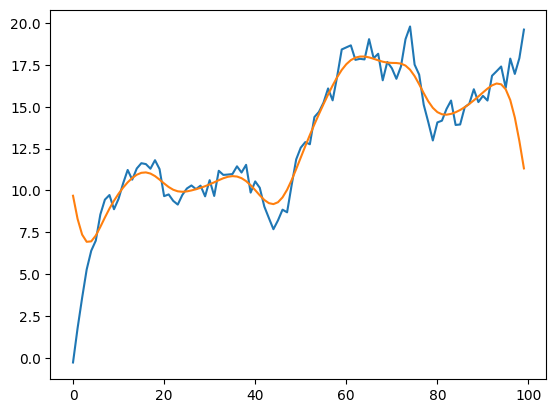

In [27]:
z = np.cumsum(np.random.normal(size=100))
plt.plot(z)
plt.plot(A @ z)
plt.show()

True


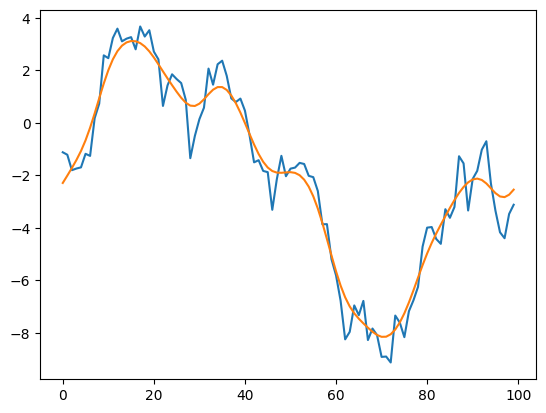

In [28]:
A = A.to_gpu()
print(check_adjoint(A))
z = cp.cumsum(cp.random.normal(size=100))
plt.plot(cp.asnumpy(z))
plt.plot(cp.asnumpy(A @ z))
plt.show()

In [29]:
response = requests.get("https://raw.githubusercontent.com/cupy/cupy/main/docs/image/cupy_logo_1000px.png")
img = Image.open(BytesIO(response.content))
img = img.convert('L')
img = np.array(img)
img = img/255.0

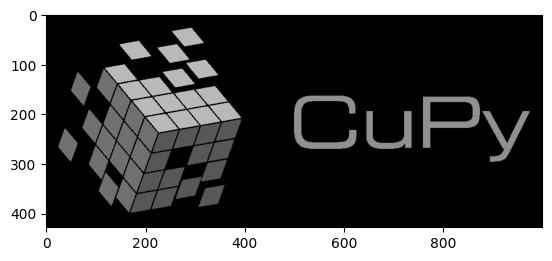

In [30]:
plt.imshow(img, cmap="gray")
plt.show()

In [31]:
A = Gaussian2DBlurOperator(img.shape, blur_sigma=10, mode="wrap")
print(check_adjoint(A))

True


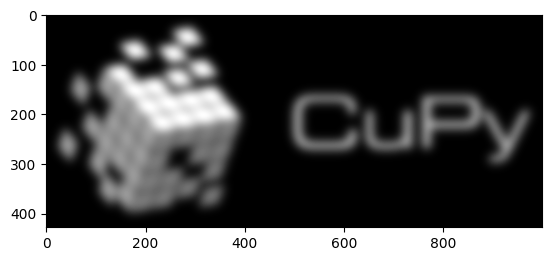

In [32]:
plt.imshow(A.matvec_shaped(img), cmap="gray")
plt.show()

True


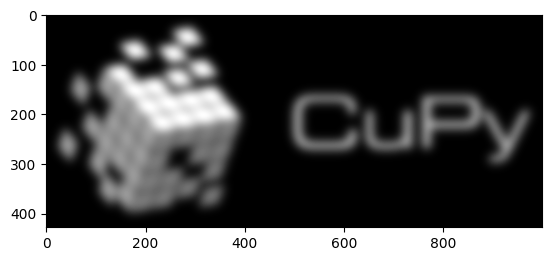

In [33]:
A = A.to_gpu()
print(check_adjoint(A))
img = cp.asarray(img)

plt.imshow(cp.asnumpy(A.matvec_shaped(img)), cmap="gray")
plt.show()

# Subsampling

In [34]:
from jlinops import Subsampling1DOperator, Subsampling2DOperator

In [35]:
n = 50
x = np.cumsum(np.random.normal(size=n))
mask = np.random.binomial(1, 0.5, size=n)

In [36]:
P = Subsampling1DOperator(mask)

In [37]:
m = P.T @ (P @ x)

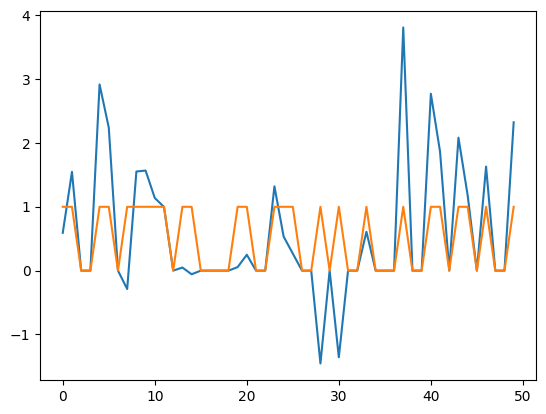

In [38]:
plt.plot(m)
plt.plot(P.mask)
plt.show()

In [39]:
response = requests.get("https://raw.githubusercontent.com/cupy/cupy/main/docs/image/cupy_logo_1000px.png")
img = Image.open(BytesIO(response.content))
img = img.convert('L')
img = np.array(img)
img = img/255.0

In [40]:
mask = np.random.binomial(1, 0.5, size=img.shape)
P = Subsampling2DOperator(mask)
backproj = (P.T @ (P @ img.flatten())).reshape(img.shape)

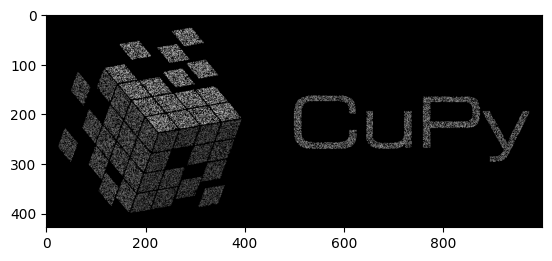

In [41]:
plt.imshow(backproj, cmap="gray")
plt.show()

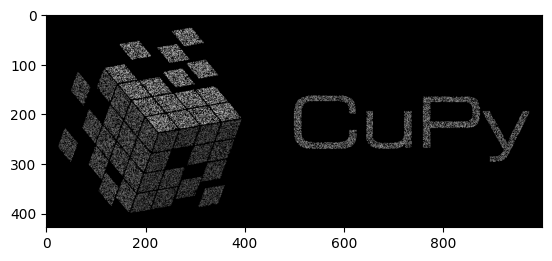

In [42]:
P = P.to_gpu()
backproj = (P.T @ (P @ cp.asarray(img).flatten())).reshape(img.shape)
plt.imshow(cp.asnumpy(backproj), cmap="gray")
plt.show()

# Blurring and subsampling

In [43]:
response = requests.get("https://raw.githubusercontent.com/cupy/cupy/main/docs/image/cupy_logo_1000px.png")
img = Image.open(BytesIO(response.content))
img = img.convert('L')
img = np.array(img)
img = img/255.0

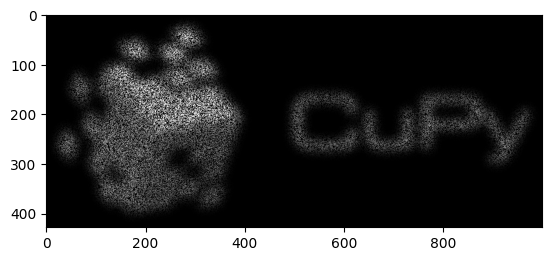

In [44]:
A = Gaussian2DBlurOperator(img.shape, blur_sigma=10, mode="wrap")
blurred = A @ img.flatten()
mask = np.random.binomial(1, 0.5, size=img.shape)
P = Subsampling2DOperator(mask)
y = P @ blurred
backproj = (P.T @ y).reshape(img.shape)

plt.imshow(backproj, cmap="gray")
plt.show()

# MatrixLinearOperator

In [6]:
from jlinops import MatrixLinearOperator
from scipy.sparse import csr_matrix

In [7]:
mat = np.random.normal(size=(100,200))
A = MatrixLinearOperator(mat)
check_adjoint(A)

True

In [8]:
A = A.to_gpu()
check_adjoint(A)

True

In [9]:
A = A.to_cpu()
check_adjoint(A)

True

In [10]:
mat = csr_matrix(mat)
A = MatrixLinearOperator(mat)
check_adjoint(A)

True

In [11]:
A = A.to_gpu()
check_adjoint(A)

True

In [12]:
A = A.to_cpu()
check_adjoint(A)

True

# Banded cholesky

In [9]:
from jlinops import banded_cholesky
import scipy.sparse as sps
from scipy.sparse import csc_matrix

In [11]:
A = sps.eye(1000)
A = csc_matrix(A)
result = banded_cholesky(A)

# Neumann2D

In [6]:
from jlinops import Neumann2D

In [7]:
response = requests.get("https://raw.githubusercontent.com/cupy/cupy/main/docs/image/cupy_logo_1000px.png")
img = Image.open(BytesIO(response.content))
img = img.convert('L')
img = np.array(img)
img = img/255.0

In [8]:
grid_shape = img.shape
R = Neumann2D(grid_shape, device="cpu")
print(check_adjoint(R))

True


In [9]:
R = R.to_gpu()
print(check_adjoint(R))

True


In [10]:
R = R.to_cpu()
type(R @ img.flatten())

numpy.ndarray

# DCT

In [11]:
from jlinops import DCT2D, dct_sqrt, dct_sqrt_pinv

In [12]:
A = DCT2D(img.shape, device="cpu")

In [13]:
L = dct_sqrt(A.T @ A, img.shape)

In [14]:
check_adjoint(L)

True

In [15]:
check_adjoint(A)

True

In [18]:
R = Neumann2D(grid_shape, device="cpu")

In [19]:
Lpinv = dct_sqrt_pinv(R.T @ R, grid_shape)

In [20]:
Lpinv.shape

(428000, 428000)

In [25]:
%%timeit
Lpinv @ np.random.uniform(size=Lpinv.shape[0])

12.3 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
Lpinv = Lpinv.to_gpu()

In [27]:
%%timeit
Lpinv @ cp.random.uniform(size=Lpinv.shape[0])

502 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# aslinearoperator

In [22]:
np.ones((5,5)).T.conj()

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [34]:
from jlinops import isshape

In [35]:
isshape( (2,3) )

True

In [24]:
from scipy.sparse import csc_matrix, coo_matrix, dia_matrix, csr_matrix

In [25]:
A = csc_matrix(np.zeros((5,5)))
A.getformat()

'csc'

In [26]:
A = coo_matrix(np.zeros((5,5)))
A.getformat()

'coo'

In [27]:
A = dia_matrix(np.zeros((5,5)))
A.getformat()

'dia'

In [28]:
A = csr_matrix(np.zeros((5,5)))
A.getformat()

'csr'